In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import glob

In [2]:
# initial parameters
epochs = 100
lr = 1e-3
batch_size = 64
img_dims = (96,96,3)

data = []
labels = []

In [3]:
# load image files from the dataset
image_files = [f for f in glob.glob(r'Data' + "/**/*", recursive=True) if not os.path.isdir(f)]
random.shuffle(image_files)

In [4]:
# converting images to arrays and labelling the categories
for img in image_files:

    image = cv2.imread(img)
    
    image = cv2.resize(image, (img_dims[0],img_dims[1]))
    image = img_to_array(image)
    data.append(image)

    label = img.split(os.path.sep)[-2] # \woman\face_1162.jpg
    if label == "woman":
        label = 1
    else:
        label = 0
        
    labels.append([label]) # [[1], [0], [0], ...]

In [5]:
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [6]:
# split dataset for training and validation
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2,
                                                  random_state=42)

In [7]:
trainY[:10]

array([[0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1]])

In [8]:
trainY = to_categorical(trainY, num_classes=2) # [[1, 0], [0, 1], [0, 1], ...]   #[man,woman]
testY = to_categorical(testY, num_classes=2)

In [9]:
# augmenting datset 
Datagen = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

In [10]:
width=img_dims[0], 
height=img_dims[1], 
depth=img_dims[2],
classes=2

In [11]:
inputShape = (96,96,3)

In [12]:
chanDim = -1

In [13]:
if K.image_data_format() == "channels_first": #Returns a string, either 'channels_first' or 'channels_last'
    inputShape = (depth, height, width)
    chanDim = 1

In [14]:
model = Sequential()

model.add(Conv2D(32, (3,3), padding="same", input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))

model.add(Conv2D(64, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))

model.add(Conv2D(128, (3,3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(classes))
model.add(Activation("sigmoid"))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0

In [16]:
# compile the model
opt = Adam(lr=lr, decay=lr/epochs)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [17]:
train_datagen = Datagen.flow(trainX, trainY, batch_size=batch_size)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [19]:
#early stopping
earlystop = EarlyStopping(monitor='val_accuracy',
                          mode="max",
                          min_delta=0.01,
                          patience=10,
                          verbose=1,
                         )

In [20]:
chckpoint = ModelCheckpoint("bestmodel.model",
                            monitor='val_accuracy',
                            save_best_only=True,
                            verbose=1,
                            mode="max"
                           )

In [21]:
History = model.fit(train_datagen,
                    validation_data=(testX,testY),
                    callbacks = [earlystop,chckpoint],
                    steps_per_epoch=len(trainX) // batch_size,
                    epochs=epochs, verbose=1)

Epoch 1/100
28/28 [==============================] - ETA: 0s - loss: 0.7860 - accuracy: 0.7209
Epoch 00001: val_accuracy improved from -inf to 0.54329, saving model to bestmodel.model
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: bestmodel.model\assets
28/28 [==============================] - 30s 1s/step - loss: 0.7860 - accuracy: 0.7209 - val_loss: 0.6859 - val_accuracy: 0.5433
Epoch 2/100
28/28 [==============================] - ETA: 0s - loss: 0.5143 - accuracy: 0.7900
Epoch 00002: val_accuracy did not improve from 0.54329
28/28 [==============================] - 27s 977ms/step - loss: 0.5143 - accuracy: 0.7900 - val_loss: 0.7027 - val_accuracy: 0.5087
Epoch 3/100
28/28 [==============================] - ETA: 0s - loss: 0.4611 - accuracy: 0.8259
Epoch 00003: val_a

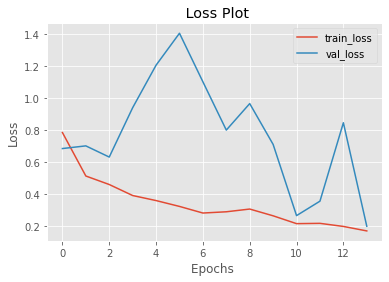

In [23]:
# plot training/validation loss/accuracy
plt.style.use("ggplot")
plt.figure()
N = 14 #upto where the model has been last saved
plt.plot(np.arange(0,N), History.history["loss"][:14], label="train_loss")
plt.plot(np.arange(0,N), History.history["val_loss"][:14], label="val_loss")
plt.title(" Loss Plot")
plt.xlabel("Epochs ")
plt.ylabel("Loss")
plt.legend(loc="upper right")

# save plot to disk
plt.savefig('loss_plot.png')

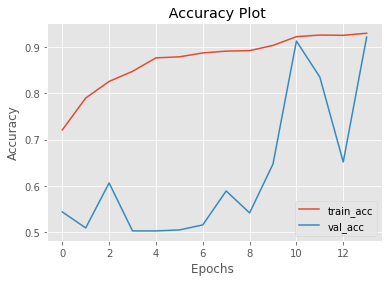

In [24]:
plt.plot(np.arange(0,N), History.history["accuracy"][:14], label="train_acc")
plt.plot(np.arange(0,N), History.history["val_accuracy"][:14], label="val_acc")
plt.title(" Accuracy Plot")
plt.xlabel("Epochs ")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

# save plot to disk
plt.savefig('Accuracy_plot.png')

# Testing

In [25]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array

In [26]:
img = load_img("Data/man/face_1.jpg")

In [27]:
img = img.resize((96,96))

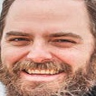

In [28]:
img

In [29]:
img = img_to_array(img)

In [30]:
img = img.reshape((1,96,96,3))/255.0

In [31]:
pred = model.predict(img)

In [32]:
if np.argmax(pred) == 0:
    print("man")
    print(pred[0][0])
else:
    print("woman")
    print(pred[0][1])

man
0.9774705


In [33]:
pred[0][0]

0.9774705